In [1]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from pytorch_tabular.utils import get_balanced_sampler, get_class_weighted_cross_entropy
import pandas as pd
import numpy as np
import random
import torch
import os
os.chdir("..")
%load_ext autoreload
%autoreload 2

from common import data_load_home_credit, find_optimal_cutoff, plot_confusion_matrix, plot_auc

from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig, NodeConfig, TabNetModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
train, test = data_load_home_credit('/media/ismaeel/Work/msds19029_thesis/dataset/home_with_missing.csv')

In [3]:
feats_total = [f for f in train.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index',
'APPROVED_SIMPLE_INTERESTS_MEAN', 'APPROVED_SIMPLE_INTERESTS_MIN']]
feats_train = [f for f in train.columns if f not in ['TARGET', 'SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index',
'APPROVED_SIMPLE_INTERESTS_MEAN', 'APPROVED_SIMPLE_INTERESTS_MIN']]
cat_features = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_TYPE_SUITE', 'WALLSMATERIAL_MODE']

In [4]:
num_features = list(set(feats_train) - set(cat_features))

In [5]:
train = train[feats_total]
test = test[feats_total]

In [6]:
train = train.reset_index()
test = test.reset_index()

In [7]:
train = train.drop(list(np.where(np.isinf(train[feats_total].values))[0]))
test = test.drop(list(np.where(np.isinf(test[feats_total].values))[0]))

In [8]:
batch_size = 256
steps_per_epoch = int(train.shape[0]/1024)
epochs = 20

data_config = DataConfig(
    target=['TARGET'],
    continuous_cols=num_features,
    categorical_cols=cat_features,
    continuous_feature_transform="quantile_normal",
    normalize_continuous_features=True
)
trainer_config = TrainerConfig(
    auto_lr_find=True,
    batch_size=batch_size,
    max_epochs=epochs,
    gpus=1,
    gradient_clip_val=10,
)

experiment_config = ExperimentConfig(project_name="pr_project", run_name="node_model", log_target="wandb",
                                    exp_watch="gradients")

optimizer_config = OptimizerConfig(lr_scheduler="OneCycleLR", 
                                   lr_scheduler_params={"max_lr":2e-3, "epochs": epochs, 
                                                        "steps_per_epoch":steps_per_epoch})

# optimizer_config = OptimizerConfig()

model_config = NodeConfig(
    task="classification",
    num_layers=3,
    num_trees=256,
    learning_rate = 1e-3,
    embed_categorical=False,
    metrics=["accuracy", "f1"]
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    experiment_config=experiment_config
)

In [9]:
weighted_loss = get_class_weighted_cross_entropy(train["TARGET"].values.ravel(), mu=0.1)

In [10]:
tabular_model.fit(train=train, test=test, loss=weighted_loss)

Global seed set to 42
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
wandb: Currently logged in as: ismaeelkanju (use `wandb login --relogin` to force relogin)


/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory saved_models exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | custom_loss     | CrossEntropyLoss | 0     
1 | backbone        | NODEBackbone     | 7.3 M 
2 | output_response | Lambda           | 0     
-----------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.267    Total estimated model params size (MB)
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which m

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /media/ismaeel/Work/ThesisandProjects/msds19029_thesis/lr_find_temp_model.ckpt
Learning rate set to 0.04365158322401657
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | custom_loss     | CrossEntropyLoss | 0     
1 | backbone        | NODEBackbone     | 7.3 M 
2 | output_response | Lambda           | 0     
-----------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.267    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
result = tabular_model.evaluate(test)
print(result)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/media/ismaeel/Work/ThesisandProjects/msds19029_thesis/env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9185932874679565, 'test_f1': 0.9185932874679565}
--------------------------------------------------------------------------------
[{'test_accuracy': 0.9185932874679565, 'test_f1': 0.9185932874679565}]


In [12]:
pred_df = tabular_model.predict(test)

Generating Predictions...:   0%|          | 0/104 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    Approved       0.96      0.70      0.81     24382
    Declined       0.17      0.70      0.28      2176

    accuracy                           0.70     26558
   macro avg       0.57      0.70      0.54     26558
weighted avg       0.90      0.70      0.77     26558

Binary: ROC AUC=0.701


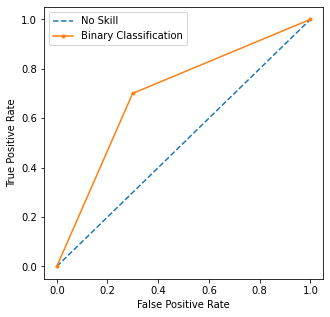

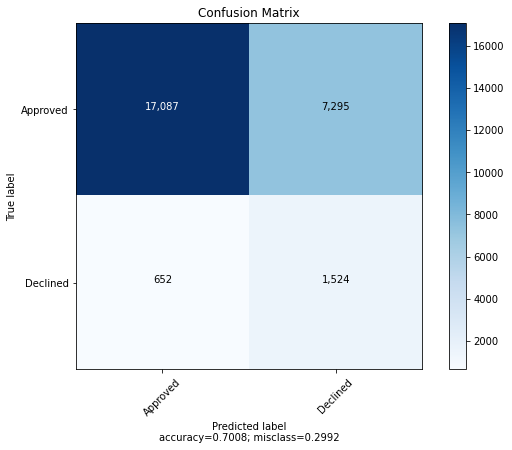

wandb: Network error resolved after 0:00:44.022886, resuming normal operation.
wandb: Network error resolved after 0:40:20.830557, resuming normal operation.
wandb: Network error resolved after 0:06:40.358358, resuming normal operation.


In [13]:
pred = pred_df['1.0_probability'].values
labels = test['TARGET'].values
th = find_optimal_cutoff(labels, pred)
pred = np.where(pred > th, 1, 0)

cm = confusion_matrix(labels, pred)
cr = classification_report(labels, pred, target_names=['Approved', 'Declined'])
print(cr)

plot_auc(labels, pred)

plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Approved', 'Declined'],
                      title        = "Confusion Matrix")